#### Import all required libraries

In [0]:
import re
import os
import json
import keras
import numpy as np
import pandas as pd
import keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from time import time
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, LSTM, CuDNNLSTM, Flatten, \
                         Activation, RepeatVector, Permute, Lambda, Bidirectional, \
                         TimeDistributed, Dropout, Layer, GRU, CuDNNGRU
from keras.layers.merge import multiply, concatenate
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

#### Please uncomment below code if you would like to run the code on google colab.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Harvard/Data')
# os.listdir()

#### Paths to different file used in this jupyter notebook

In [0]:
DATA_FILE_PATH = './questions.csv'
CONTRACTIONS_FILE_PATH = './contractions.json'
EMBEDDING_FILE = "./glove.840B.300d.txt"

In [ ]:
# Create empty directories for saving logs and models
!mkdir logs
!mkdir models

In [0]:
# Read data into memory using pandas library as dataframe
# Read the contractions file also for performing data cleaning steps
data = pd.read_csv(DATA_FILE_PATH)
contractions = json.load(open(CONTRACTIONS_FILE_PATH))

#### Sample Data

In [6]:
data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


#### Shape of the data

In [7]:
data.shape

(404351, 6)

#### Data Analysis
    1. Copy data to another variable data1
    2. Change 0 and 1 labels in 'is_duplicate' variable to 'Not Duplicate' and 'Duplicate' respectively
    3. Create a plot to visualize the number of duplicate and non duplicate questions in the original dataset

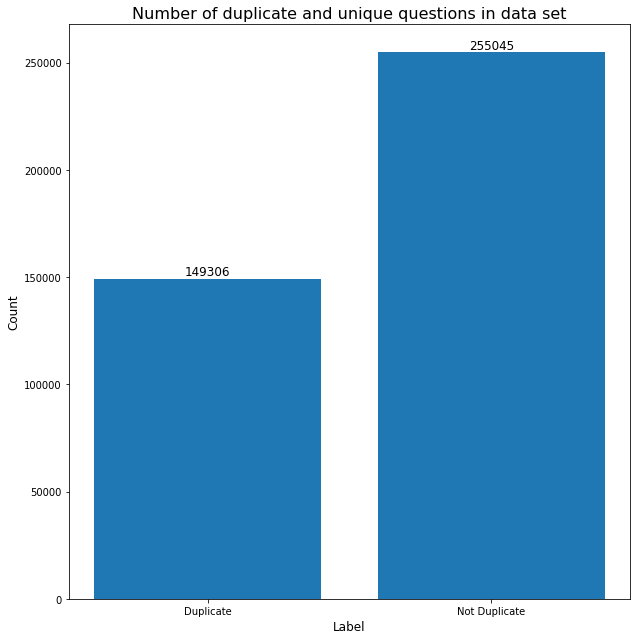

In [8]:
data1 = data.copy()
data1.loc[data1.is_duplicate == 0, 'is_duplicate'] = 'Not Duplicate'
data1.loc[data1.is_duplicate == 1, 'is_duplicate'] = 'Duplicate'
labels, counts = np.unique(data1.is_duplicate, return_counts=True)
plt.figure(figsize=(9, 9))
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
bar = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
for b in bar:
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), '%d' % int(b.get_height()), ha='center', va='bottom', fontsize=12)
plt.title('Number of duplicate and unique questions in data set', fontsize=16)
plt.tight_layout()
plt.show()

Create new variables to measure the number of characters and words in question1 and question2. This analysis helps us in determining the sequence length of RNN cells. Plot the frequency of these new variables to visualize them.

In [0]:
def char_word_counter(ques):
    return len(ques.split())

data1['question1'] = data1['question1'].fillna("")
data1['question2'] = data1['question2'].fillna("")
data1.loc[:, 'question1_word_count'] = data1.loc[:, 'question1'].apply(char_word_counter)
data1.loc[:, 'question1_char_count'] = data1.loc[:, 'question1'].apply(len)
data1.loc[:, 'question2_word_count'] = data1.loc[:, 'question2'].apply(char_word_counter)
data1.loc[:, 'question2_char_count'] = data1.loc[:, 'question2'].apply(len)

word_counter = data1.question1_word_count.append(data1.question2_word_count)
char_counter = data1.question1_char_count.append(data1.question2_char_count)

#### Plot distribution of number of words present in each question.

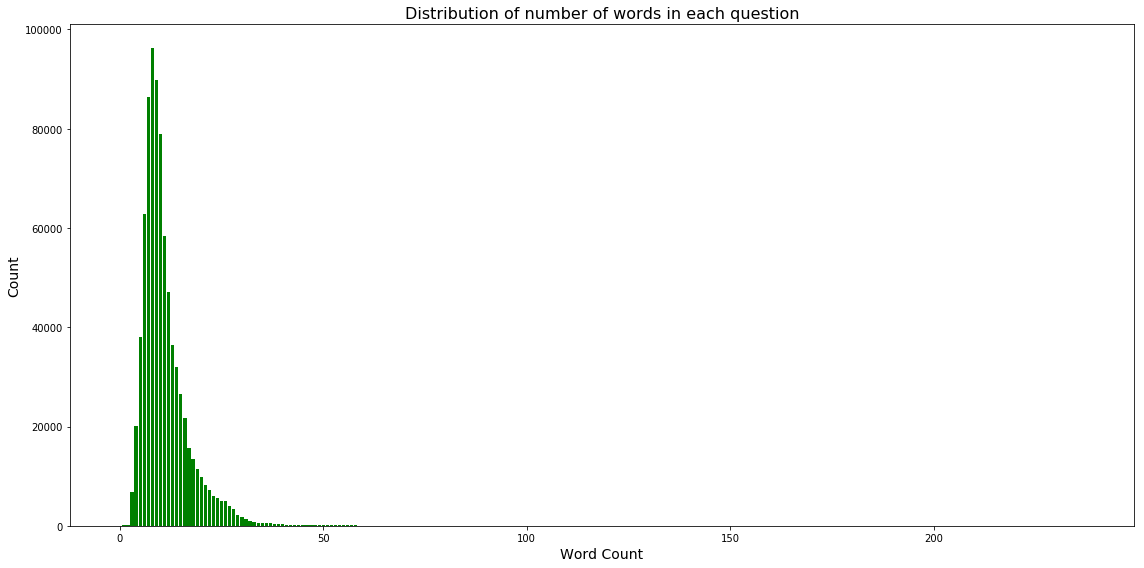

In [10]:
labels, counts = np.unique(word_counter, return_counts=True)
plt.figure(figsize=(16, 8))
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Count', fontsize=14)
bar = plt.bar(labels, counts, align='center', color='green')
plt.title('Distribution of number of words in each question', fontsize=16)
plt.tight_layout()
plt.show()

#### Plot distribution of number of characters present in each question.

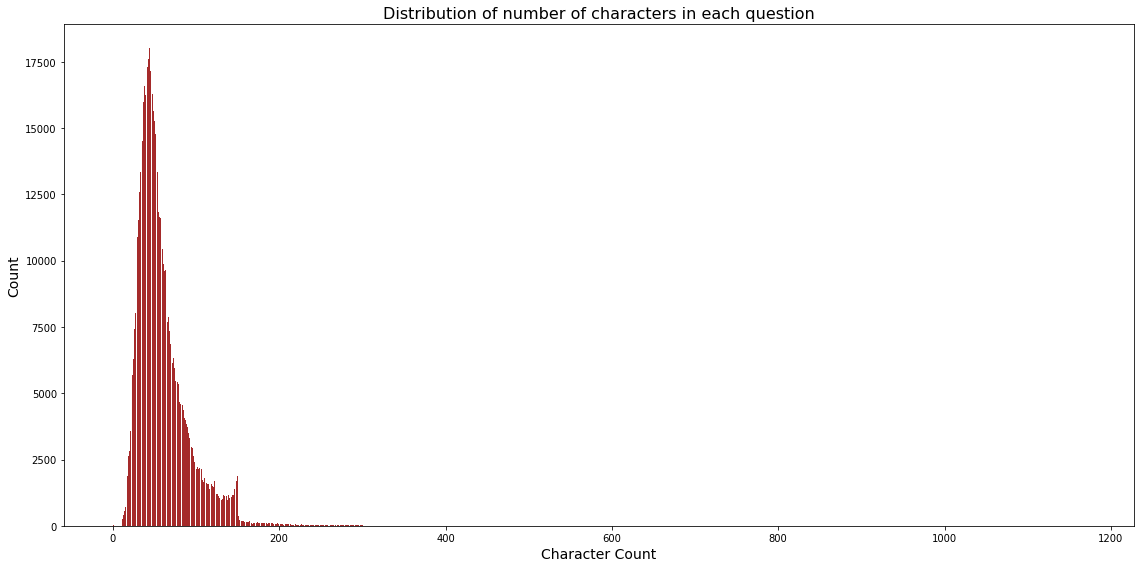

In [11]:
labels, counts = np.unique(char_counter, return_counts=True)
plt.figure(figsize=(16, 8))
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Count', fontsize=14)
bar = plt.bar(labels, counts, align='center', color='brown')
plt.title('Distribution of number of characters in each question', fontsize=16)
plt.tight_layout()
plt.show()

1. MIN_WORD_OCCURRENCE indicates how many times a word should be present in the data before it is added to vocabulary.
2. REPLACE_WORD indicates the token that should be replaced with if an unknown word comes during testing phase.
3. EMBEDDING_DIM is the embedding dimension.
4. MAX_SEN_LEN indicates maximum length of the sentence. If a question is above this length, remaining words a cutoff.

In [0]:
MIN_WORD_OCCURRENCE = 1
REPLACE_WORD = "UNK"
# EMBEDDING_FILE = "./glove.840B.300d.txt"
EMBEDDING_DIM = 300
MAX_SEN_LEN = 20

#### Data augmentation
In this step, we tried to increase the number of duplicate records by creating questions matching with the same question. This process is done for duplicate questions of fields question1 and question2 only. It helped in creating more number of duplicate questions in the dataset.

In [0]:
def data_augmentation(data):
    temp_df1 = data[data['is_duplicate'] == 1].reset_index(drop=True)[['id', 'question1']]
    temp_df1.rename(columns={'id': 'qid1'}, inplace=True)
    temp_df1.insert(1, 'qid2', temp_df1['qid1'])
    temp_df1.insert(0, 'id', range(data.shape[0], data.shape[0] + len(temp_df1)))
    temp_df1['question2'] = temp_df1['question1'] 
    temp_df1['is_duplicate'] = 1
    
    temp_df2 = data[data['is_duplicate'] == 1].reset_index(drop=True)[['id', 'question2']]
    temp_df2.rename(columns={'id': 'qid2'}, inplace=True)
    temp_df2.insert(0, 'qid1', temp_df2['qid2'])
    temp_df2.insert(0, 'id', range(data.shape[0] + temp_df1.shape[0],
                                   data.shape[0] + temp_df1.shape[0] + len(temp_df2)))
    temp_df2.insert(3, 'question1', temp_df2['question2'])
    temp_df2['is_duplicate'] = 1
    
    data = pd.concat([data, temp_df1, temp_df2]).reset_index(drop=True)
    return data

### Data Cleaning:
1.	In the first stage, we converted all the text to lower case.
2.	We converted all the words such as “I’m”, “we’ve” to “I am”, “we have” respectively. This process is named as contraction process in this process.
3.	Then, we replaced all types of empty characters to a single white space character.
4.	We then removed any character other than alphabets from the text.
5.	Removed all the stop words from the text.

In [0]:
def data_preprocess(question):
    question = question.lower()
    question = contraction_process(question)
    question = re.sub(r'\W+', ' ', question)
    question = re.sub('[^a-zA-Z ]+', '', question)
    question = ' '.join([word for word in question.split() if not word in set(stopwords.words('english'))])
    return question

def contraction_process(question):
    for word in question.split():
        if word in contractions:
            question = question.replace(word, contractions[word.lower()])
    return question

Create embedding index for each word present in the embedding file. First we need to open the file and iteratively read contents in each line so that the first word is the line is the word that shoud be added as key to embeddings_index dictionary and the embedding vector of that word as value to the same dictionary.

In [0]:
def get_embeddings(file=EMBEDDING_FILE, dim=EMBEDDING_DIM):
    embeddings_index = {}
    f = open(file, encoding='utf-8')
    for line in f:
        values = line.split()
        if len(values) == dim + 1:
          word = values[0]
          coefs = np.asarray(values[1:], dtype="float32")
          embeddings_index[word] = coefs
    f.close()
    return embeddings_index

embeddings_index = get_embeddings()

In the next step we need to create an big matrix by intialization all the values to zeros and then iteratively add values of each word from embeddngs_index to this matrix. This matrix is used in the siamese neural network.

Call Data augmentation function to create more data.

In [18]:
data = data_augmentation(data)
data.shape

(702963, 6)

Complete data preprocessing steps by calling respective functions.

In [23]:
# Create a copy of the main data and apply data prepocessing steps on question1 and question2
df = data.copy()
df.loc[:, 'cleaned1'] = df.loc[:, 'question1'].fillna('')
df.loc[:, 'cleaned2'] = df.loc[:, 'question2'].fillna('')
df.loc[:, 'cleaned1'] = df.loc[:, 'cleaned1'].apply(data_preprocess)
df.loc[:, 'cleaned2'] = df.loc[:, 'cleaned2'].apply(data_preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Creating embedding matrix:**
1.	First step in creating the embedding matrix is to first create indices for all the words present in the Glove embedding file. We need to open the file and read line by line. 
2.	In each line needs to be split by space. First word should be added to the dictionary as key and the vector should be added to the value.
3.	Once the embedding indices are created we need to iterate through the question1 and question2 and create tokens.
4.	Once the tokens are created, we need to search for these tokens in the embedding indices and add them to an embedding matrix.
5.	This embedding matrix will act as input to the Siamese neural network.


In [0]:
MAX_FEATURES = 100000
tokenizer = Tokenizer(filters="", num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df.cleaned1.values + df.cleaned2.values)
word_index = tokenizer.word_index
VOCAB_SIZE = min(len(word_index) + 1, MAX_FEATURES)

def create_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_FEATURES: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix()

#### Pad input sequences. Here we used post padding and the maximum length of each sequence for RNN cell is 20 tokens

In [0]:
data_1 = pad_sequences(tokenizer.texts_to_sequences(df.cleaned1), maxlen=MAX_SEN_LEN, padding='post')
data_2 = pad_sequences(tokenizer.texts_to_sequences(df.cleaned2), maxlen=MAX_SEN_LEN, padding='post')

#### Create Batch_size and other global variables for training purpose

In [0]:
BATCH_SIZE = 256
NUM_EPOCHS = 10
NUM_RNN_UNITS = 512

Create first LSTM layer as function so that it can be initialized with different types of cells depending on whether there is gpu or not

In [0]:
def lstm(units):
    if len(K.tensorflow_backend._get_available_gpus()):
        return CuDNNLSTM(units,
                         recurrent_initializer='glorot_uniform',
                         return_sequences=True,
                         recurrent_regularizer=l2(l=0.01))
    else:
        return LSTM(units,
                    recurrent_activation='sigmoid',
                    recurrent_initializer='glorot_uniform',
                    return_sequences=True,
                    recurrent_dropout=0.2,
                    recurrent_regularizer=l2(l=0.01))

Create first GRU layer as function so that it can be initialized with different types of cells depending on whether there is gpu or not

In [0]:
def gru(units):
    if len(K.tensorflow_backend._get_available_gpus()):
        return CuDNNGRU(units,
                         recurrent_initializer='glorot_uniform',
                         return_sequences=True,
                         recurrent_regularizer=l2(l=0.01))
    else:
        return GRU(units,
                    recurrent_activation='sigmoid',
                    recurrent_initializer='glorot_uniform',
                    return_sequences=True,
                    recurrent_dropout=0.2,
                    recurrent_regularizer=l2(l=0.01))

Create embedding layer for input of siamese network

In [0]:
# Create embeddin layer with VOCAB SIze and 300 embedding dimentions. We need to pass the embedded matrix created from
# Stanford GLOVE model to this layer. This will pre process all the text before RNN layer consume output from this layer.
def create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAXIMUM_LENGTH, embedding_matrix):
    embedding_layer = Embedding(input_dim = VOCAB_SIZE,
                                output_dim = EMBEDDING_DIM,
                                input_length = MAXIMUM_LENGTH,
                                weights = [embedding_matrix],
                                trainable = False)
    return embedding_layer

#### Base Network:
1. Here we created a based network depending on different configurations of RNN cells. THey can be either LSTM or GRU and single layer or double layers and unidirectional or bidirectional
2. We have used bandhau attention.

We created network with two types of main RNN cells. One is Gated Recurrent Units (GRU) and Long Short-Term Memory (LSTM) cells. We tested both unidirectional and bidirectional cells to see the performance of the model. In each recurrent unit we have added regularization to reduce overfitting of the model. Base Siamese network is created with single layer RNN units and two layers RNN units. To reduce over fitting of the model, we added dropout layer. We added Bahdanau attention to further improve performance of the model.

#### Single Layer GRU Network

In [0]:
# This is base network that will used across all the models with minor modifications with respect to number of layer in the network
# and type of RNN layer.
# First the text of fixed length is passed to the embedding layer which will create vector of contexts.
# Then this input is passed through the RNN cells
# Immediately dropout layer is applied so that overfitting can be reduced during training.
# We need to flatten this output.
# Attention is applied by applying softmax functions and then repeating this for all the RNN cells
# We multiply the x1 and x2 to get results after attention.

def single_gru_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = gru(NUM_RNN_UNITS)(embedded)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 1)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Single Layer LSTM Network

In [0]:
def single_lstm_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = lstm(NUM_RNN_UNITS)(embedded)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 1)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Two Layer GRU Network

In [0]:
def double_gru_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = gru(NUM_RNN_UNITS)(embedded)
    x1 = gru(NUM_RNN_UNITS)(x1)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 1)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Two Layer LSTM Network

In [0]:
def double_lstm_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = lstm(NUM_RNN_UNITS)(embedded)
    x1 = lstm(NUM_RNN_UNITS)(x1)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 1)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Single Layer Bidirectional LSTM Network

In [0]:
def single_bidirectional_lstm_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = Bidirectional(lstm(NUM_RNN_UNITS), merge_mode='concat')(embedded)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 2)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Two Layer Bidirectional LSTM Network

In [0]:
def double_bidirectional_lstm_network(_input):
    embedded = create_embedding_layer(VOCAB_SIZE, EMBEDDING_DIM, MAX_SEN_LEN, embedding_matrix)(_input)
    x1 = Bidirectional(lstm(NUM_RNN_UNITS), merge_mode='concat')(embedded)
    x1 = Bidirectional(lstm(NUM_RNN_UNITS), merge_mode='concat')(x1)
    x1 = Dropout(0.2)(x1)
    x2 = TimeDistributed(Dense(1, activation='tanh'))(x1)
    x2 = Flatten()(x2)
    x2 = Activation('softmax')(x2)
    x2 = RepeatVector(NUM_RNN_UNITS * 2)(x2)
    x2 = Permute([2, 1]) (x2)
    x3 = multiply([x1, x2])
    x3 = Lambda(lambda xin: K.sum(xin, axis=1))(x3)
    return x3

#### Loss Functions:
As shown in the paper, we tried to create four different loss functions.
    1.	Euclidean Distance 
    2.	Manhattan Distance
    3.	Weighted Manhattan Distance
    4.	Cosine Similarity
    5.	Custom SoftMax Loss Function*

* Tried creating Custom SoftMax Loss function which showed superior results when compared to other loss functions. But we couldn’t successfully write code for this loss function due to input/output shape compatibility issues. We used Weighted Manhattan Distance in all our models

In [0]:
class EuclideanDist(Layer):

    def __init__(self, **kwargs):
        self.result = None
        super(EuclideanDist, self).__init__(**kwargs)

    def build(self, input_shape):
        super(EuclideanDist, self).build(input_shape)

    def call(self, x, **kwargs):
        self.result = K.sqrt(K.maximum(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True), K.epsilon()))
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
    
    
class ManhattanDist(Layer):

    def __init__(self, **kwargs):
        self.result = None
        super(ManhattanDist, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ManhattanDist, self).build(input_shape)

    def call(self, x, **kwargs):
        self.result = K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
    
    
class WeigthedManhattanDist(Layer):

    def __init__(self, **kwargs):
        self.result = None
        super(WeigthedManhattanDist, self).__init__(**kwargs)

    def build(self, input_shape):
        self.weight = self.add_weight(name='trainable_weight', shape=(1, ), initializer='he_normal', trainable=True)
        super(WeigthedManhattanDist, self).build(input_shape)

    def call(self, x, **kwargs):
        self.result = self.weight * K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
    
class CosineSimilarity(Layer):

    def __init__(self, **kwargs):
        self.result = None
        super(CosineSimilarity, self).__init__(**kwargs)

    def build(self, input_shape):
        super(CosineSimilarity, self).build(input_shape)

    def call(self, x, **kwargs):
        normalized_x1 = K.l2_normalize(x[0], axis=-1)
        normalized_x2 = K.l2_normalize(x[1], axis=-1)
        self.result = -K.mean(normalized_x1 * normalized_x2, axis=-1, keepdims=True)
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
     
# class SoftMaxCustomLoss(Layer):
#     def __init__(self, **kwargs):
#         self.result = None
#         super(SoftMaxCustomLoss, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.weight = self.add_weight(name='trainable_weight', shape=(input_shape[0][1] * 4, 2), initializer='he_normal',
#                                       trainable=True)
#         self.bias = self.add_weight(name='trainable_bias', shape=(2, ), initializer='zeros', trainable=True)
#         super(SoftMaxCustomLoss, self).build(input_shape)

#     def call(self, x, **kwargs):
#         vector1 = x[0]
#         vector2 = x[1]
#         vector3 = K.square(x[0] - x[1])
#         vector4 = K.dot(x[0], x[1])
#         vector = concatenate([vector1, vector2, vector3, vector4])
#         self.result = K.softmax(K.bias_add(K.dot(K.relu(vector), self.weight), self.bias))
#         return self.result

#     def compute_output_shape(self, input_shape):
#         return K.int_shape(self.result)

### Evaluation Metrics:

In [0]:
#  Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.
# Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
# F1 Score is the weighted average of Precision and Recall. 
# Therefore, this score takes both false positives and false negatives into account. 
# Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy,
# especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives 
# have similar cost. If the cost of false positives and false negatives are very different, 
# it’s better to look at both Precision and Recall.

# Source: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

def recall_(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def F1_score_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision * recall)/(precision + recall + K.epsilon()))

#### Training Model:

We ran the model with a batch size of 256 for 10 epochs. The number of RNN units used in the model are 256. We optimized the neural network using Adam optimizer. We calculated different metrics like accuracy, F1 score, precision and recall.

We first split the data into train validation and test sets in 80:20 ratio. We again split train validation in ration of 80:20 ratio.

The model is saved which has best weights. An early stopping call back is placed so that if there is no improvement in the model performance after 3 continuous epochs, the training stops and model with lowest validation loss are saved. The tensor board logs are also saved in logs directory.

The change in loss is visualized using a simple line plot.


In [0]:
def create_train_test_data(data_1, data_2, df):
    X = np.concatenate([data_1[:, np.newaxis], data_2[:, np.newaxis]], axis=1)
    y = df.is_duplicate.values[:, np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test_data(data_1, data_2, df)

#### Model Design
After creating the base network, we pass input1 and input2 for question1 and question2 to the loss function. This creates the loss and then we concatenate all Siamese output1 and Siamese output2 and loss. Then we slowly tried to reduce the number of parameters in the by creating a network similar in shape of funnel which finally outputs duplicate or not.

#### Training Single Layer GRU Network

Train on 449896 samples, validate on 112474 samples
Epoch 1/10
449896/449896 [==============================] - 69s 153us/step - loss: 0.2605 - acc: 0.8322 - F1_score_: 0.8719 - precision_: 0.8409 - recall_: 0.9081 - val_loss: 0.1169 - val_acc: 0.8476 - val_F1_score_: 0.8888 - val_precision_: 0.8291 - val_recall_: 0.9584
Epoch 2/10
449896/449896 [==============================] - 68s 151us/step - loss: 0.1026 - acc: 0.8728 - F1_score_: 0.9021 - precision_: 0.8830 - recall_: 0.9233 - val_loss: 0.1038 - val_acc: 0.8683 - val_F1_score_: 0.9012 - val_precision_: 0.8610 - val_recall_: 0.9460
Epoch 3/10
449896/449896 [==============================] - 68s 151us/step - loss: 0.0932 - acc: 0.8876 - F1_score_: 0.9131 - precision_: 0.8970 - recall_: 0.9310 - val_loss: 0.1067 - val_acc: 0.8673 - val_F1_score_: 0.9020 - val_precision_: 0.8500 - val_recall_: 0.9613
Epoch 4/10
449896/449896 [==============================] - 68s 151us/step - loss: 0.0859 - acc: 0.8992 - F1_score_: 0.9220 - precision

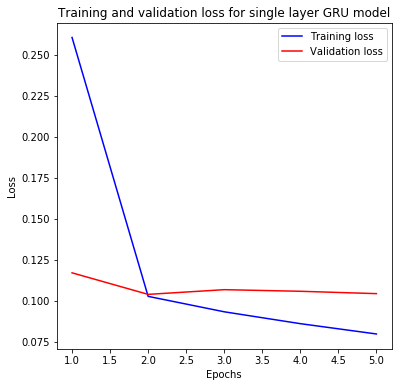

In [41]:
import warnings
warnings.filterwarnings("ignore")

# Clear Keras Session
K.clear_session()

# Take in input1 and input2 as question1 and question2
input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

# Create base network for both input1 and input2
siamese_output_1 = single_gru_network(input_1)
siamese_output_2 = single_gru_network(input_2)

# Apply weighted loss function on both outputs of siamese network
similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
# Concateneate the output and similarity measure
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
# Apply dense to reduce to the number of parameters till the final layer
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)

#Create model
single_gru_model = Model(inputs=[input_1, input_2], outputs=[similarity])

# Compile the model with mean squared error and Adam optimizer
single_gru_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])


# Save the model
model_filepath = './models/single_gru_model.h5'

# Create call backs to complete early stop if the change in model loss is insignificant
# Save the model 
# Create tensorboard logs
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

# Start training the model with train valid split of 4:1
single_gru_trained = single_gru_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=1)

# Evaluate the model on test data and note the performance metrics.
_, accuracy, f1_score, precision, recall = single_gru_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("Single Layer GRU Accuracy:   {0:.2f}".format(accuracy))
print("Single Layer GRU Precision:  {0:.2f}".format(precision))
print("Single Layer GRU Recall:     {0:.2f}".format(recall))
print("Single Layer GRU F1_Score:   {0:.2f}".format(f1_score))

# Plot the loss during training phase for each epoch.
loss = single_gru_trained.history['loss']
val_loss = single_gru_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for single layer GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training Single Layer LSTM Network

140593/140593 [==============================] - 21s 148us/step
Single Layer LSTM Accuracy:   0.88
Single Layer LSTM Precision:  0.92
Single Layer LSTM Recall:     0.89
Single Layer LSTM F1_Score:   0.90


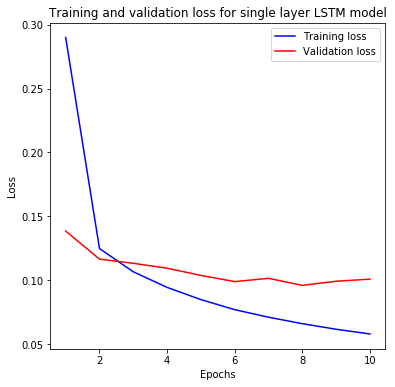

In [42]:
K.clear_session()

input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

siamese_output_1 = single_lstm_network(input_1)
siamese_output_2 = single_lstm_network(input_2)

similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)
single_lstm_model = Model(inputs=[input_1, input_2], outputs=[similarity])
single_lstm_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])

model_filepath = './models/single_lstm_model.h5'
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

single_lstm_trained = single_lstm_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=0)

_, accuracy, f1_score, precision, recall = single_lstm_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("Single Layer LSTM Accuracy:   {0:.2f}".format(accuracy))
print("Single Layer LSTM Precision:  {0:.2f}".format(precision))
print("Single Layer LSTM Recall:     {0:.2f}".format(recall))
print("Single Layer LSTM F1_Score:   {0:.2f}".format(f1_score))

loss = single_lstm_trained.history['loss']
val_loss = single_lstm_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for single layer LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training Two Layer GRU Network

140593/140593 [==============================] - 30s 217us/step
Two Layer GRU Accuracy:   0.89
Two Layer GRU Precision:  0.88
Two Layer GRU Recall:     0.96
Two Layer GRU F1_Score:   0.91


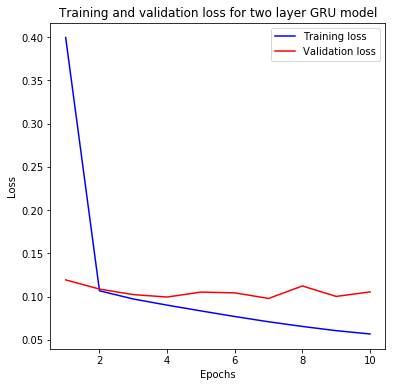

In [43]:
K.clear_session()

input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

siamese_output_1 = double_gru_network(input_1)
siamese_output_2 = double_gru_network(input_2)

similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)
double_gru_model = Model(inputs=[input_1, input_2], outputs=[similarity])
double_gru_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])

model_filepath = './models/double_gru_model.h5'
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

double_gru_trained = double_gru_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=0)

_, accuracy, f1_score, precision, recall = double_gru_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("Two Layer GRU Accuracy:   {0:.2f}".format(accuracy))
print("Two Layer GRU Precision:  {0:.2f}".format(precision))
print("Two Layer GRU Recall:     {0:.2f}".format(recall))
print("Two Layer GRU F1_Score:   {0:.2f}".format(f1_score))

loss = double_gru_trained.history['loss']
val_loss = double_gru_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for two layer GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training Two Layer LSTM Network

140593/140593 [==============================] - 36s 254us/step
Two Layer LSTM Accuracy:   0.88
Two Layer LSTM Precision:  0.88
Two Layer LSTM Recall:     0.94
Two Layer LSTM F1_Score:   0.91


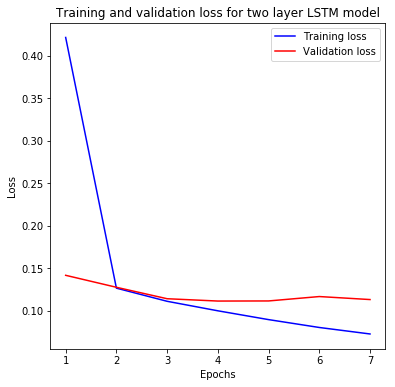

In [44]:
K.clear_session()

input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

siamese_output_1 = double_lstm_network(input_1)
siamese_output_2 = double_lstm_network(input_2)

similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)
double_lstm_model = Model(inputs=[input_1, input_2], outputs=[similarity])
double_lstm_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])

model_filepath = './models/double_lstm_model.h5'
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

double_lstm_trained = double_lstm_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=0)

_, accuracy, f1_score, precision, recall = double_lstm_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("Two Layer LSTM Accuracy:   {0:.2f}".format(accuracy))
print("Two Layer LSTM Precision:  {0:.2f}".format(precision))
print("Two Layer LSTM Recall:     {0:.2f}".format(recall))
print("Two Layer LSTM F1_Score:   {0:.2f}".format(f1_score))

loss = double_lstm_trained.history['loss']
val_loss = double_lstm_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for two layer LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training Single Layer Bidirectional LSTM Network

140593/140593 [==============================] - 35s 248us/step
Single Layer Bidirectional LSTM Accuracy:   0.85
Single Layer Bidirectional LSTM Precision:  0.82
Single Layer Bidirectional LSTM Recall:     0.99
Single Layer Bidirectional LSTM F1_Score:   0.89


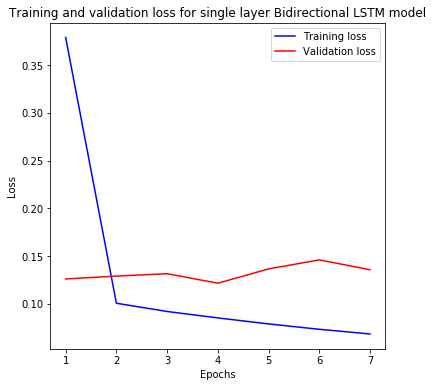

In [45]:
K.clear_session()

input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

siamese_output_1 = single_bidirectional_lstm_network(input_1)
siamese_output_2 = single_bidirectional_lstm_network(input_2)

similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)
single_bidirectional_lstm_model = Model(inputs=[input_1, input_2], outputs=[similarity])
single_bidirectional_lstm_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])

model_filepath = './models/single_bidirectional_lstm_model.h5'
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

single_bidirectional_lstm_trained = single_bidirectional_lstm_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=0)

_, accuracy, f1_score, precision, recall = single_bidirectional_lstm_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("Single Layer Bidirectional LSTM Accuracy:   {0:.2f}".format(accuracy))
print("Single Layer Bidirectional LSTM Precision:  {0:.2f}".format(precision))
print("Single Layer Bidirectional LSTM Recall:     {0:.2f}".format(recall))
print("Single Layer Bidirectional LSTM F1_Score:   {0:.2f}".format(f1_score))

loss = single_bidirectional_lstm_trained.history['loss']
val_loss = single_bidirectional_lstm_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for single layer Bidirectional LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Training Two Layer Bidirectional LSTM Network

140593/140593 [==============================] - 74s 524us/step
TWO Layer Bidirectional LSTM Accuracy:   0.88
Two Layer Bidirectional LSTM Precision:  0.93
Two Layer Bidirectional LSTM Recall:     0.88
Two Layer Bidirectional LSTM F1_Score:   0.90


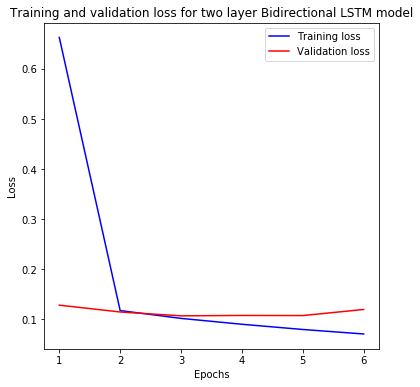

In [46]:
K.clear_session()

input_1 = Input(shape=(MAX_SEN_LEN,), dtype='float32')
input_2 = Input(shape=(MAX_SEN_LEN,), dtype='float32')

siamese_output_1 = double_bidirectional_lstm_network(input_1)
siamese_output_2 = double_bidirectional_lstm_network(input_2)

similarity_measure = WeigthedManhattanDist()([siamese_output_1, siamese_output_2])
siamese_output = concatenate([siamese_output_1, siamese_output_2, similarity_measure])
dense_1 = Dense(16)(siamese_output)
dense_2 = Dense(8)(dense_1)
dense_3 = Dense(4)(dense_2)
dense_4 = Dense(2)(dense_3)
similarity = Dense(1, activation='sigmoid')(dense_4)
double_bidirectional_lstm_model = Model(inputs=[input_1, input_2], outputs=[similarity])
double_bidirectional_lstm_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy',
                                                                     F1_score_, 
                                                                     precision_, 
                                                                     recall_])

model_filepath = './models/double_bidirectional_lstm_model.h5'
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                  ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max'),
                  TensorBoard(log_dir="logs/{}".format(time()))]

double_bidirectional_lstm_trained = double_bidirectional_lstm_model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                          validation_split=0.2, callbacks=callbacks_list, verbose=0)

_, accuracy, f1_score, precision, recall = double_bidirectional_lstm_model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

print("TWO Layer Bidirectional LSTM Accuracy:   {0:.2f}".format(accuracy))
print("Two Layer Bidirectional LSTM Precision:  {0:.2f}".format(precision))
print("Two Layer Bidirectional LSTM Recall:     {0:.2f}".format(recall))
print("Two Layer Bidirectional LSTM F1_Score:   {0:.2f}".format(f1_score))

loss = double_bidirectional_lstm_trained.history['loss']
val_loss = double_bidirectional_lstm_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for two layer Bidirectional LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
df[['question1', 'cleaned1']].head()

,question1,cleaned1
0,What is the step by step guide to invest in sh...,step step guide invest share market india
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,story kohinoor koh noor diamond
2,How can I increase the speed of my internet co...,increase speed internet connection using vpn
3,Why am I mentally very lonely? How can I solve...,mentally lonely solve
4,"Which one dissolve in water quikly sugar, salt...",one dissolve water quikly sugar salt methane c...
